# Model Fixed Curve - Parametric Modulation Analysis
## Useful if you are anticipating that the amplitude of the response may be different for each stimulus dimension or will change over time
### PMOD -  Modulated regressor
### EVENT - Event regressor

In [1]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze' 
mask_filenames = []
cope_files = []
for SID in sids:
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_' 
                               + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(mask_filenames_glob)
    subjcopes_glob = glob(proj_dir + '/scndlvl/wmaze_MRthesis/fixed_before_conditional/model_fixed_PMA/' 
                          + SID + '/fixedfx/cope_PMA*')
    subjcopes_glob.sort()
    cope_files.append(subjcopes_glob)    
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 2:
        print(SID)

## Cell to double-check the array indexing

In [2]:
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7])

(0, 'lh-hippocampus_warped')
(1, 'lh_caudate_anat_mask_warped')
(2, 'rh_caudate_anat_mask_warped')
(3, 'lh-dmPFC_warped')
(4, 'lh-mPFC_lausanne_warped')
(5, 'lh-mPFC_fs_warped')
(6, 'lh-motor_warped')
(7, 'lh-mPFC_fs-3reg_warped')
(8, 'rh-hippocampus_warped')
(9, 'rh-dmPFC_warped')
(10, 'rh-mPFC_lausanne_warped')
(11, 'rh-mPFC_fs_warped')
(12, 'rh-motor_warped')
(13, 'rh-mPFC_fs-3reg_warped')
(14, 'lh-putamen_warped')
(15, 'rh-putamen_warped')


In [3]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[5][i].split('/')[-1][5:-7]) 

(0, 'PMA_event')
(1, 'PMA_pmod')


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
all_data = {'subjid':[],
            #HPC
            'lhhp_event':[], 'rhhp_event':[], 'lhhp_pmod':[], 'rhhp_pmod':[],
            #mPFC
            'lhmpfc_event':[], 'rhmpfc_event':[], 'lhmpfc_pmod':[], 'rhmpfc_pmod':[],
            #Caudate
            'lhcaud_event':[], 'rhcaud_event':[], 'lhcaud_pmod':[], 'rhcaud_pmod':[],
            #Putamen
            'lhput_event':[], 'rhput_event':[], 'lhput_pmod':[], 'rhput_pmod':[]}

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    lh_hp_img = nb.load(mask_filenames[i][0])
    rh_hp_img = nb.load(mask_filenames[i][8])
    lh_mpfc_img = nb.load(mask_filenames[i][5])
    rh_mpfc_img = nb.load(mask_filenames[i][11])
    lh_caud_img = nb.load(mask_filenames[i][1])
    rh_caud_img = nb.load(mask_filenames[i][2])
    lh_put_img = nb.load(mask_filenames[i][14])
    rh_put_img = nb.load(mask_filenames[i][15])
    
    event_img = nb.load(cope_files[i][0])
    pmod_img = nb.load(cope_files[i][1])
    
    region = ['hp', 'mpfc', 'caud', 'put']
    contrasts = ['event', 'pmod']
   
    for r in region:
        for c in contrasts:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(c,r))
            all_data['lh{0}_{1}'.format(r,c)].append(np.mean(lh_data))            
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(c,r))
            all_data['rh{0}_{1}'.format(r,c)].append(np.mean(rh_data))

all_data_df = pd.DataFrame(all_data)    

### Combine the two hemispheres to create one regional average

In [5]:
plot = {}
region = ['hp', 'mpfc', 'caud', 'put']
contrasts = ['event', 'pmod']

for r in region:
    for c in contrasts:
        all_data_df['{0}_all_{1}'.format(r,c)] = (all_data_df['lh{0}_{1}'.format(r,c)] 
                                                  + all_data_df['rh{0}_{1}'.format(r,c)])/2.
        plot['{0}_{1}'.format(r,c)] = all_data_df['{0}_all_{1}'.format(r,c)]
plot_df = pd.DataFrame.from_dict(plot)

## Hippocampus

In [6]:
hp_chart = {}
for x in ['event', 'pmod']:
    hp_chart['{0}'.format(x)] = all_data_df['hp_all_{0}'.format(x)] 
hp_chart_df = pd.DataFrame.from_dict(hp_chart)

In [7]:
hp_chart_df

,event,pmod
0,-1.973424,5.198054
1,-15.266747,8.906802
2,-4.610958,8.004866
3,-2.142749,1.560627
4,-9.138647,11.411491
5,-2.000123,2.058329
6,0.923628,-0.890328
7,-2.502999,0.668068
8,0.189416,-6.548111
9,-3.887820,6.124732


Mean pmod:  2.6071553573
STD pmod:  7.78380237217

Mean event:  -2.98967858553
STD event:  6.0685348072

T-test: PMOD vs. EVENT (1.814051195247482, 0.085494715057253562)
Cohen's d =  1.10540642485


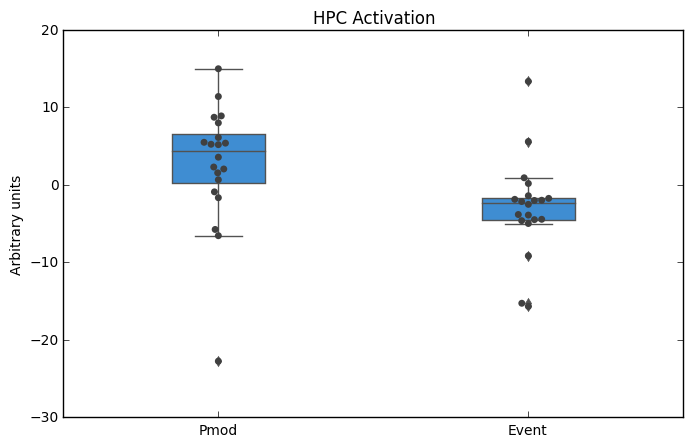

In [26]:
for d in ['pmod', 'event']:
    print "Mean {0}: ".format(d), np.mean(hp_chart['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(hp_chart['{0}'.format(d)])
    print ""
    
print 'T-test: PMOD vs. EVENT', stats.ttest_rel(hp_chart['pmod'], hp_chart['event'])[:]
cohens_d = ((np.average(hp_chart['pmod']) - np.average(hp_chart['event'])) 
            / (sqrt((np.std(hp_chart['pmod'], ddof = 1)) ** 2 + np.std(hp_chart['event'], ddof = 1) ** 2) / 2))
print "Cohen's d = ", cohens_d

N = 2
conditions = ['Pmod', 'Event']
hp_allsubjs = [hp_chart['pmod'], hp_chart['event']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (8,5))
ax0 = sns.boxplot(data = hp_allsubjs, color = "#278fea", width = 0.3)
ax2 = sns.swarmplot(data = hp_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("HPC Activation")
plt.show()

## mPFC

In [11]:
mpfc_chart = {}
for x in ['event', 'pmod']:
    mpfc_chart['{0}'.format(x)] = all_data_df['mpfc_all_{0}'.format(x)] 
mpfc_chart_df = pd.DataFrame.from_dict(mpfc_chart)

In [12]:
mpfc_chart_df

,event,pmod
0,-5.421373,10.876139
1,-10.101738,9.633662
2,3.083599,-1.013089
3,1.096994,-0.784419
4,-9.803432,9.646922
5,1.157664,2.067021
6,1.987643,1.410453
7,-13.418323,10.025493
8,-4.340292,-3.685529
9,1.420123,-1.214732


Mean pmod:  1.99057776742
STD pmod :  5.39300256042

Mean event:  -2.01246821741
STD event :  5.32525878824

T-test: PMOD vs. EVENT (1.7826520667220167, 0.090629565357687028)
Cohen's d =  1.02959010111


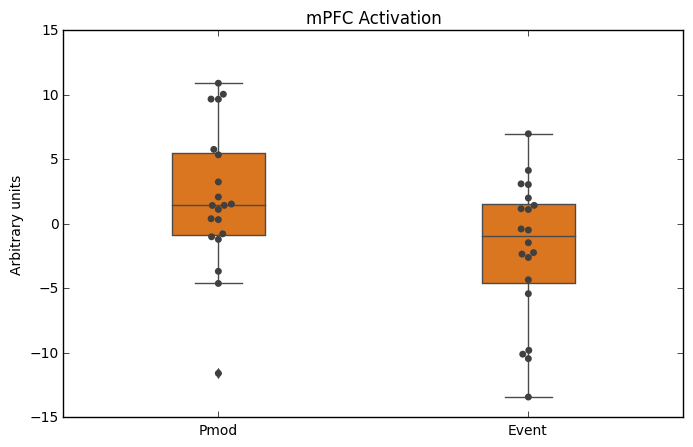

In [25]:
for d in ['pmod', 'event']:
    print "Mean {0}: ".format(d), np.mean(mpfc_chart['{0}'.format(d)])
    print "STD {0} : ".format(d), np.std(mpfc_chart['{0}'.format(d)])
    print ""
    
print 'T-test: PMOD vs. EVENT', stats.ttest_rel(mpfc_chart['pmod'], mpfc_chart['event'])[:]
cohens_d = ((np.average(mpfc_chart['pmod']) - np.average(mpfc_chart['event'])) 
            / (sqrt((np.std(mpfc_chart['pmod'], ddof = 1)) ** 2 + np.std(mpfc_chart['event'], ddof = 1) ** 2) / 2))
print "Cohen's d = ", cohens_d

N = 2
conditions = ['Pmod', 'Event']
mpfc_allsubjs = [mpfc_chart['pmod'], mpfc_chart['event']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (8,5))
ax0 = sns.boxplot(data = mpfc_allsubjs, color = "#f97401", width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("mPFC Activation")
plt.show()

## Caudate

In [15]:
caud_chart = {}
for x in ['event', 'pmod']:
    caud_chart['{0}'.format(x)] = all_data_df['caud_all_{0}'.format(x)] 
caud_chart_df = pd.DataFrame.from_dict(caud_chart)

In [16]:
caud_chart_df

,event,pmod
0,11.013535,-9.440007
1,-6.339293,2.579224
2,14.396790,-15.411898
3,11.202985,-11.995262
4,4.288951,-10.343600
5,5.618348,-4.697719
6,5.773709,-4.259453
7,12.766853,-19.470194
8,2.517809,-5.530631
9,7.023232,-7.677667


Mean pmod:  -9.23536851555
STD pmod :  9.50380107203

Mean event:  8.16993668638
STD event :  8.11003992286

T-test: PMOD vs. EVENT (-4.3651335882163753, 0.00033312129958818073) **
Cohen's d =  -2.71568235096


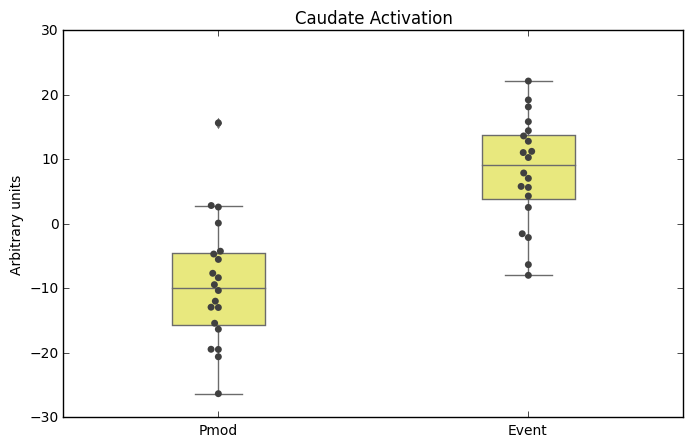

In [24]:
for d in ['pmod', 'event']:
    print "Mean {0}: ".format(d), np.mean(caud_chart['{0}'.format(d)])
    print "STD {0} : ".format(d), np.std(caud_chart['{0}'.format(d)])
    print ""
    
print 'T-test: PMOD vs. EVENT', stats.ttest_rel(caud_chart['pmod'], caud_chart['event'])[:], "**"
cohens_d = ((np.average(caud_chart['pmod']) - np.average(caud_chart['event'])) 
            / (sqrt((np.std(caud_chart['pmod'], ddof = 1)) ** 2 + np.std(caud_chart['event'], ddof = 1) ** 2) / 2))
print "Cohen's d = ", cohens_d

N = 2
conditions = ['Pmod', 'Event']
caud_allsubjs = [caud_chart['pmod'], caud_chart['event']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (8,5))
ax0 = sns.boxplot(data = caud_allsubjs, color = "#f9f96d", width = 0.3)
ax2 = sns.swarmplot(data = caud_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate Activation")
plt.show()

## Putamen

In [19]:
put_chart = {}
for x in ['event', 'pmod']:
    put_chart['{0}'.format(x)] = all_data_df['put_all_{0}'.format(x)] 
put_chart_df = pd.DataFrame.from_dict(put_chart)

In [20]:
put_chart_df

,event,pmod
0,6.669243,-6.007362
1,-12.353111,7.426419
2,4.664163,-4.737754
3,3.661405,-5.417554
4,-2.681495,2.774496
5,-2.495115,10.340534
6,-2.883244,5.718156
7,-1.394817,-4.181900
8,0.580957,-4.675390
9,0.847581,1.272512


Mean pmod:  -2.27955058217
STD pmod:  7.85789919854

Mean event:  1.76760861203
STD event:  6.84812791456

T-test: PMOD vs. EVENT (-1.231985528810055, 0.23298424610159327)
Cohen's d =  -0.756903198141


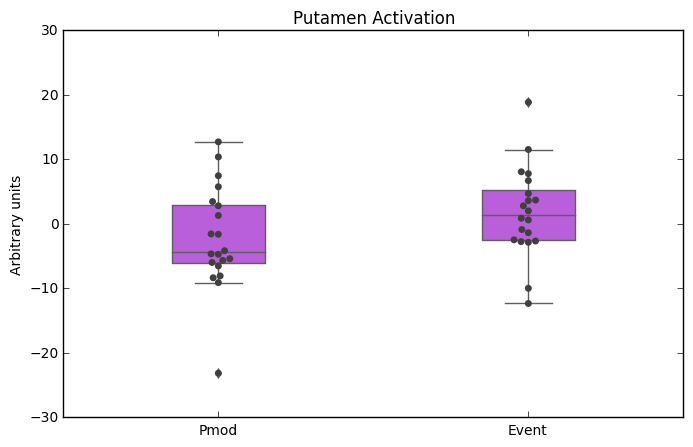

In [27]:
for d in ['pmod', 'event']:
    print "Mean {0}: ".format(d), np.mean(put_chart['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(put_chart['{0}'.format(d)])
    print ""
    
print 'T-test: PMOD vs. EVENT', stats.ttest_rel(put_chart['pmod'], put_chart['event'])[:]
cohens_d = ((np.average(put_chart['pmod']) - np.average(put_chart['event'])) 
            / (sqrt((np.std(put_chart['pmod'], ddof = 1)) ** 2 + np.std(put_chart['event'], ddof = 1) ** 2) / 2))
print "Cohen's d = ", cohens_d

N = 2
conditions = ['Pmod', 'Event']
put_allsubjs = [put_chart['pmod'], put_chart['event']]
ind = np.arange(N)
width = 0.5
fig, ax = plt.subplots(figsize = (8,5))
ax0 = sns.boxplot(data = put_allsubjs, color = "#c34aef", width = 0.3)
ax2 = sns.swarmplot(data = put_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen Activation")
plt.show()